# Uproot Tutorial

Uproot is a Python library whose sole function is to read and write ROOT files. It should be noted that this library does not perform analysis, graphics, or any other tasks; its purpose is exclusively data input and output (I/O).

For all other operations, Uproot integrates seamlessly with the Python scientific ecosystem, such as NumPy, Awkward Array, and Pandas for calculations, or matplotlib and hist for histograms.

We will use an MC simulation file of the event Z $\rightarrow$ $\mu$ $\mu$.


### 1. Reading the Dataset

First, we import uproot and open a direct connection to the remote file using its URL. Then, we inspect its contents to understand what data we have available in the ntuple.

In [11]:
import uproot

file = uproot.open(
    "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"
)

The object file created by uproot behaves very much like a Python dictionary, allowing you to inspect its contents efficiently.

If we only want a list of the names of all objects stored in the file, we can use the .keys() method.

In [12]:
file.keys()

['Events;75', 'Events;74']

 This operation is very fast because it does not need to read the object data. It is the equivalent in uproot to the ROOT command .ls, but it returns a standard Python list.

Similarly, to find out what type of object is stored (a TTree, a TH1F histogram, etc.), it is more useful to use the  .classnames()method.

In [13]:
file.classnames()

{'Events;75': 'TTree', 'Events;74': 'TTree'}

This method returns a dictionary that associates the name of each object with the name of its class. Like .keys(), it is a very efficient operation that does not load heavy data from the file.

In [14]:
tree = file["Events"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


When executing .show() on the tree object, a detailed summary of all variables (or “branches”) available for analysis is printed.

In [15]:
# tree["nMuon"].array()
tree["nMuon"].array(entry_start=1_000, entry_stop=2_000)

<Array [2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 4, 4, 1, 3, 4, 3] type='1000 * uint32'>

The .array()/.awkward() method reads the data and converts it into a NumPy or Awkward array.

### 2. Reading Multiple TBranches at Once

To read multiple branches, we use the .arrays() method to read data. The difference is that now, instead of passing the name of a single branch, we pass it a list of branch names.

In [16]:
Muons = tree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass"])

In [17]:
Muons

<Array [{Muon_pt: [...], ...}, ..., {...}] type='61540413 * {Muon_pt: var *...'>

Finally, uproot reads all these branches and returns them as a single  Array in the Jets variable. This array has a special structure, similar to a “record” or a dictionary, where each of the branches we requested becomes a field in this array.

### 3. Selecting TBranches by name

We can use the filter_name argument to select branches based on a pattern instead of having to write each name in a list.

In [24]:
tree.keys(filter_name="Muon_*")

tree.arrays(filter_name="Muon_*", entry_stop=1_000)

<Array [{Muon_pt: [...], ...}, ..., {...}] type='1000 * {Muon_pt: var * flo...'>

The asterisk (*) acts as a wildcard that matches any sequence of characters.

### 4. Scaling up, making a plot

We first read all branches from the TTree for the first 1,000 events and stores them in a single, structured Awkward Array called Muons.

In [25]:
Muons = tree.arrays(entry_stop=1_000)

cut = Muons["nMuon"] >= 2

pt0 = Muons["Muon_pt", cut, 0]
pt1 = Muons["Muon_pt", cut, 1]

eta0 = Muons["Muon_eta", cut, 0]
eta1 = Muons["Muon_eta", cut, 1]

phi0 = Muons["Muon_phi", cut, 0]
phi1 = Muons["Muon_phi", cut, 1]

In [26]:
import numpy as np
import hist

massdimuon = np.sqrt(2*pt0*pt1*(np.cosh(eta0-eta1) - np.cos(phi0 - phi1)))

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f458e7109d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

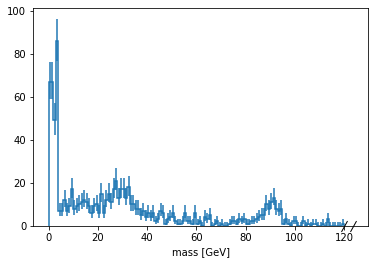

In [27]:
masshist = hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]"))
masshist.fill(massdimuon)
masshist.plot()

In [27]:
tree.keys(filter_name=["nMuon", "/Muon_(pt|eta|phi)/"])

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi']

0.02476806582367265
0.04953244301431646
0.07414066265691133
0.09883069845501362
0.12372555900786691
0.14857022490245556
0.1733401756663544
0.19790541542189521
0.2231366240587303
0.24903843268000167
0.2746961577914662
0.3004716591680982
0.3266033492495411
0.35272515964428125
0.37907369909915944
0.4053174618766371
0.4309308746433015
0.4559705993523313
0.4818679393653078
0.5026042967894935


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f456094bb50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

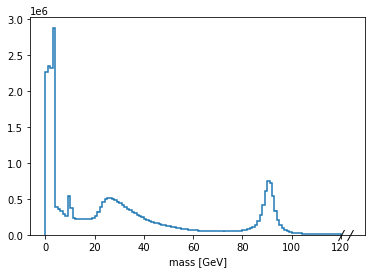

In [28]:
masshist = hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]"))

for muons in tree.iterate(filter_name=["nMuon", "/Muon_(pt|eta|phi)/"]):
    cut = muons["nMuon"] == 2

    pt0 = muons["Muon_pt", cut, 0]
    pt1 = muons["Muon_pt", cut, 1]

    eta0 = muons["Muon_eta", cut, 0]
    eta1 = muons["Muon_eta", cut, 1]

    phi0 = muons["Muon_phi", cut, 0]
    phi1 = muons["Muon_phi", cut, 1]
    
    mass = np.sqrt(2*pt0*pt1*(np.cosh(eta0-eta1) - np.cos(phi0 - phi1)))
    masshist.fill(mass)
    
    print(masshist.sum() / tree.num_entries)
    
masshist.plot()

### 5. Getting data into NumPy or Pandas

In all of the above examples, the array, arrays, and iterate methods return Awkward Arrays. The Awkward Array library is useful for exactly this kind of data (jagged arrays: more in the next lesson), but you might be working with libraries that only recognize NumPy arrays or Pandas DataFrames.

Use library="np" or library="pd" to get NumPy or Pandas, respectively.

In [29]:
tree["nMuon"].array(library="np", entry_stop=10_000)

tree.arrays(library="np", entry_stop=10_000)

#tree.arrays(library="pd", entry_stop=10_000)

{'nMuon': array([2, 2, 1, ..., 2, 2, 2], dtype=uint32),
 'Muon_pt': array([array([10.763697, 15.736523], dtype=float32),
        array([10.53849 , 16.327097], dtype=float32),
        array([3.2753265], dtype=float32), ...,
        array([30.238283, 13.035936], dtype=float32),
        array([17.35597 , 15.874119], dtype=float32),
        array([39.6421  , 42.273067], dtype=float32)], dtype=object),
 'Muon_eta': array([array([ 1.0668273, -0.5637865], dtype=float32),
        array([-0.42778006,  0.34922507], dtype=float32),
        array([2.2108555], dtype=float32), ...,
        array([-1.1984524, -2.0278058], dtype=float32),
        array([-0.83613676, -0.8279834 ], dtype=float32),
        array([-2.090575 , -1.0396558], dtype=float32)], dtype=object),
 'Muon_phi': array([array([-0.03427272,  2.5426154 ], dtype=float32),
        array([-0.2747921,  2.5397813], dtype=float32),
        array([-1.2234136], dtype=float32), ...,
        array([-2.2813563 ,  0.60287297], dtype=float32),
      